# **ECG Practice**

## **Detección de casos de enfermedad cardiovascular a través del análisis de electrocardiogramas (ECG)**

---

**Referencia**: [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

**Resumen de la referencia**:

A partir de los datasets de  *PhysionNet’s MIT-BIH* y *PTB Diagnostics* se consigue realizar una clasificación de diferentes tipos de electrocardiogramas con una precisión del **93.4%** para las arritmias y **95.9%** para MI con el uso de RNN.

**Contenido**

* [importación de librerías y globales ](#1)
* [análisis de datos](#2)
    * Abrimos los datos
    * Vemos los tipos de datos, las primeras líneas del df y su distribución
    * Imprimimos algunos electrocardiogramas para ver qué pinta tienen
* [preprocesamiento](#3)
    * Separamos el df en X,y
    * Creamos arrays con los índices de los ejemplos que pertenecen a cada categoría.
    * Vemos el counts por cada label, para ver su distribución.
* [visualización de datos](#4)
    * plot del conteo por categoria, que visualizar la sobrerrepresentación de la label <0>
    * plot del valor medio de cada categoria y su rango de valores para cada timestamp
* [preparacion de datos](#5)
    * Binarizamos las labels con OneHot
    * Hacemos un shuffle
    * Cambiamos las dimensiones
    * Hacemos un split entre train y test
* [definición de modelo CNN y entrenamiento](#6)
    




----
<a href='#1'>

### Importación de librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

----
<a href='#2'>

### análisis de datos


In [4]:
# step 1 - importar el dataset
df = pd.read_csv(f"./data/mitbih_train.csv", encoding='utf-8', header=None)

# step 2 - ¿qué forma tiene el dataset?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [5]:
# step 3 - ¿cómo son los datos? muestras las cinco primeras filas
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Este es el dataset de hoy. Esta vez, cada columna representa una lectura del electrocardiograma (recogido a 125Hz). 

Si en total hay 187 lecturas, en estas columnas tenemos alrededor de segundo y medio de pulsaciones. La última columna contiene la categoría a la que pertenecen estas pulsaciones. En total hay cinco, cada una representada por un número: 

- Normal: 0
- Arritmia prematura (atrial, aberrante-atrial, nodal o supra-ventricular) : 1
- Contracción prematura ventricular o escape ventricular: 2
- Fusión de la contracción ventricular y normal: 3
- Resucitación, fusión de normal y resucitación o inclasificable: 4


In [26]:
label_names = ('normal', 'arritmia_prematura', 'contracción_prematura_ventricular', 'fusión_contraccion_ventricular', 'resucitación')

In [7]:
# step 4 - Distribución de los datos
df.describe()

# NOTAS: 
# La columna de las labels tiene max = 4 (0..4 etiquetas), std = 1.14, 0.25,0.5,0.75 = 0

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,...,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,...,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991342,0.826013,0.429472,0.166000,0.147878,0.158798,0.145324,0.144424,0.150000,0.148734,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910506,0.578767,0.341727,0.258993,0.287628,0.298237,0.295391,0.290832,0.283636,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


El rango para todas las columnas excepto para la ultima es de 0 .. 1 por lo que se trata de un dataset previamente normalizado.

En el paper de referencia se lo siguiente en referencia a la unificación de datos de las dos fuentes:

>The steps used for extracting beats from an ECG signal are as follows (see Fig. 1):
> 1. Splitting the continuous ECG signal to 10s windows andselect a 10s window from an ECG signal.
> 2. Normalizing the amplitude values to the range of between zero and one.
> 3. Finding the set of all local maximums based on zero crossings of the first derivative.
> 4. Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums.
> 5. Finding the median of R-R time intervals as the nominal heartbeat period of that window (T ).
> 6. For each R-peak, selecting a signal part with the length equal to 1.2T .
> 7. Padding each selected part with zeros to make its length equal to a predefined fixed length.

Es decir, del 'raw data' al que no tenemos acceso:
- Se seleccionaron ''windows'' de 10s cada uno
- Se normalizó y estandarizó el rango de los datos para que tuviesen la misma amplitud y duracción.

Cada ECG Beat que tenemos es una ponderación de un ''window'' dado de 10s procedente de dos fuentes.

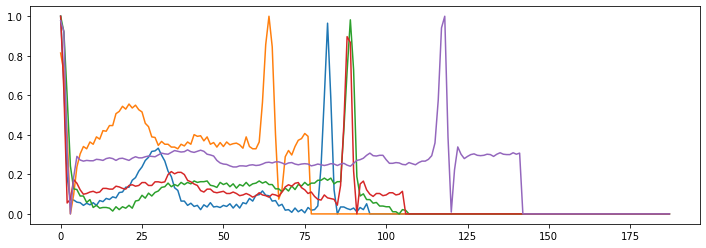

In [8]:
# step 5 - Cómo es cada uno de esos electrocardiogramas?

f, ax = plt.subplots(figsize=(12,4))

for _ in range(2, 100, 20):
    df.iloc[_, :].plot.line(ax = ax)

plt.show()

----
<a href='#3'>

### preprocesamiento

In [17]:
# step 1 - separación del frame en X (features) e y (labels)
X, y = df.iloc[:, :-1], df.iloc[:, -1].astype(int)

print(X.shape); print(y.shape)

(87554, 187)
(87554,)


In [18]:
# step 2 - creamos arrays con los índices de los ejemplos que pertenecen a cada categoría.

# opcion 1 - compatible con arrays
index_by_k = list(map(lambda k: np.argwhere(y.values == k).flatten(), y.unique()))
#index_by_k = list(map(lambda arr: np.reshape(arr, newshape=arr.size), index_by_k)) # esto se puede hacer conun faltten
# arrays -> lista dcon sublistas
# np.argwhere es en vertical mientras que np.where es en horizontal:

#       np.argwhere > [[[0], [1]], 
#                     [[2], [3]]]
#       np.where    > [([0, [], [2, 3],)]  # where is a tuple with (true_result, false_result)

# opcion 2 . con pandas - no sirve con arrays
index_by_label = list()

for _ in y.unique():
    index_by_label.append(df[df.iloc[:, -1] == _].index.tolist())

# 
print(index_by_k[0][:10])
print(index_by_label[0][:10])

[0 1 2 3 4 5 6 7 8 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [25]:
# step 3 - contamos cuanto ejemplos tenemos en cada categoría:

y.value_counts().sort_index().to_dict()

{0: 72471, 1: 2223, 2: 5788, 3: 641, 4: 6431}

De la categoria 3 (fusión_contraccion_ventricular) tenemos sólo 641 (< 1%) por lo que va a ser muy dificil de predecir; nuestro target es sobre todo el 0 y el 4 (arritmia y resucitación, que son los mencionados en el paper), que tienen, en orde, un 82.75% y un 7.35% de representación sobre el total de las labels.

----

<a href='#4'>

### visualización de datos

* Visualización del conteo 
* Rango de valores por cada electrocardiograma.

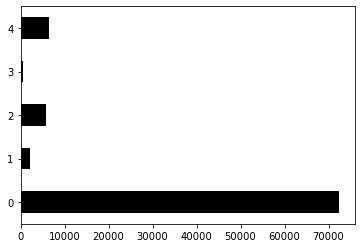

In [28]:
f, ax = plt.subplots()
ax = y.value_counts().sort_index().plot.barh(color = 'k')
plt.show()

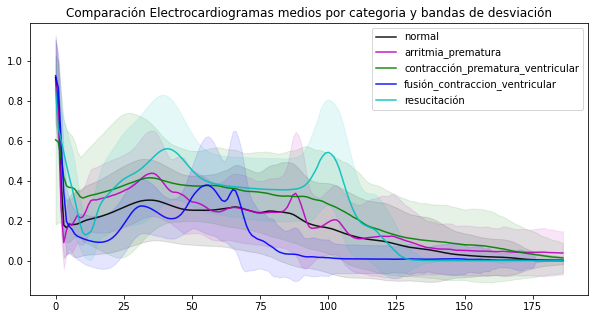

In [29]:
# Comparamos gráficamente los electrocardiogramas, dibujando el valor medio para cada tipo y su rango de valores.

f, ax = plt.subplots(figsize = (10,5))
colors = ['k', 'm', 'g', 'b', 'c']

for k in range(y.unique().size):
    mean = X.iloc[X.index.isin(index_by_k[k]), :].mean()
    stdev = X.iloc[X.index.isin(index_by_k[k]), :].std()

    ax.plot(mean, color = colors[k], alpha = 0.9, label = label_names[k])
    ax.fill_between(mean.index, mean-stdev, mean+stdev, color = colors[k], alpha = 0.1)
    ax.legend()

plt.title('Comparación Electrocardiogramas medios por categoria y bandas de desviación')
plt.show()

---
<a href='#5'>

### preparacion de datos

Existen varias formas de binarizar las labels: 

* OneHotEncoding: devuelve una matrix en la forma one-hot; funciona con multilabels.
    * Se aplica en casos cuando las labels no son ordinales
    * Los valores no son cercanos entre ellos (no lineales)
    
* LabelBinarizer: devuelve una matriz en la forma one-vs-all, toma cada input como una clase (no funciona con multilabels)
    * En casos en que las labels sean ordinales (tengan un orden entre ellas)
    * Cuando necesitemos asignar numeros cercanos para categorías similares.

Estos casos funcionan bien cuando no tenemos muchas labels, si no, nos encontramos n el problema de una alta dimensionalidad; en estos casos:
* LabelEncoder: devuelve un array; pero en los casos de que no haya ordinalidad, implica que el mean() del array es un valor no significativo.

In [15]:
# ------------ INTERLUDE -----------------------------
# no conocías np.newaxis 
a = y.values[np.newaxis, :].shape
b = y.values[:, np.newaxis].shape # == np.argwhere 

print(a, end='\t'); print(b)

(1, 87554)	(87554, 1)


In [30]:
# %%timeit

from sklearn.preprocessing import MultiLabelBinarizer
# option 1 - OneHotENcoder     -  57.8 ms  ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# opcion 2- pd.get_dummies()   -  1.73 ms  ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

y = y.apply(lambda f: str(int(f))) 

enc = MultiLabelBinarizer()
y_bin = enc.fit_transform(y)
y_labels = enc.classes_

print(y_bin) # devuelve un tensor

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [31]:
# Una vez que tenemos la binarización de y
# Hacemos un chequeo entre categorías:

is_unique = {l: (np.where(y_bin.T[i] == 1)[0] == index_by_k[i]).all() 
            for i, l in enumerate(y_labels)}

print(is_unique)

{'0': True, '1': True, '2': True, '3': True, '4': True}


In [33]:
print(y.shape, end = '\t'); print(y_bin.shape, end = '\t'); print(type(y_bin))

(87554,)	(87554, 5)	<class 'numpy.ndarray'>


In [32]:
from sklearn.utils import shuffle

# Randomizamos los frame de entrenamiento y target

random_shuffle_state = 42
X_shuffle, y_shuffle = shuffle(X, y_bin)

Para poder introducir los datos en el modelo, necesitamos que cada punto de información esté solo dentro del array (no podemos dar un array como valor). 

Antes teníamos los datos estructurados así:

> $ X = [[a_1,a_2,a_3...,a_n],[b_1,b_2,b_3...,b_n]...[z_1,z_2,z_3,z_n]] $

Para poder usarlos necesitamos aislar cada uno de esos valores, sin eliminar su agrupación por ejemplos. Es decir:

> $ X = [[[a_1],[a_2],[a_3]...,[a_n]],[[b_1],[b_2],[b_3]...,[b_n]]...[[z_1],[z_2],[z_3],[z_n]] $

In [34]:
#%%timeit
# matrix X : 
# [   [row_1]  # size = 187 (n_cols)  
#     [row_2]  # size = 187 (n_cols)    
# ]   -------  # size = 16372598 (n_rows)
Xc = np.expand_dims(X_shuffle, axis = 2)
# 3.38 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

In [35]:
X_shuffle = Xc
print(X_shuffle.shape); print(y_shuffle.shape)
print(type(X_shuffle)); print(type(y_shuffle))

(87554, 187, 1)
(87554, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Una vez que hemos hecho todo, hacemos un train_test_split()

In [36]:
#Dos lineas de código[0]
from sklearn.model_selection import train_test_split
import tensorflow as tf

random_split_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_shuffle, y_shuffle, 
    test_size = .25, 
    random_state = random_split_state
)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data  = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-04-15 16:42:56.813711: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-15 16:42:56.815709: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 16:42:56.817632: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


----
<a href='#6'>

###  definición de modelo y entrenamiento

En el paper, pg.4, se plantea un modelo de CNN basado en 5 capas convolucionales que copiamos a continuación:

In [46]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization, Input
from keras.utils import np_utils

from keras import models, layers, optimizers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 
import itertools

- ¿Cual es la longitud de la entrada? (Esta será la cantidad de neuronas que tendremos en la primera capa).
- ¿Cuantas neuronas tendremos en nuestra última capa? 
- También necesitamos un batch_size si queremos entrenar la red neuronal con SGD.

In [44]:
signal_length = X_shuffle.shape[1]  # cada pulsación se compone de 187 señales --> longitud de la capa de entrada
n_classes =     y_labels.size       # y_labels es un range(0,5) obtenido en MultiLabelBinarizer() --> longitud de la capa final
batch_size =    250                 # p.e.

Siguiendo la arquitectura mencionada en el paper definimos una red neuronal con:
* 5 capas ocultas convolucionales de una dimension, con 32 neuronal y un kernel_size de 5.
> NOTA: se definen dos convolucionales con una activación en medio de relu y sin dropout, en vez de eso se mete un stride = 2
* Como layers vistas hay:
    * De entrada una Conv1D de 32 neuronas
    * 

In [99]:
def get_conv(i:int):
    """ Central Architecture for Conv Layers in model, deffined as:
            Conv -> ReLu -> Conv -> +  -> ReLu -> Pool
    """
    conv_layer = Sequential(
        [
            Conv1D(32, kernel_size=5),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling1D(pool_size=(2), strides=2)
        ], name = f"residual_conv_{i}"
    )

    return conv_layer



def get_model(
    signal_length: int,
    n_classes: int
    ):
    """ Modelo sacado del paper de referencia, basado en 5 layers convolucionales 
        con una entrada de:        Input() -> Conv
        y una salida tal que:      FC -> ReLu -> fc -> Softmax 

        En total, tiene que haber 13 layers con pesos
    """

    model = Sequential()

    # layer_0
    model.add(Conv1D(32, kernel_size=(5), input_shape=(signal_length, 1)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(get_conv(i=1))
    model.add(get_conv(i=2))
    model.add(get_conv(i=3))
    model.add(get_conv(i=4))
    model.add(get_conv(i=5))

    # 
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes,  activation='softmax'))

    return model


In [100]:
model = get_model(signal_length, n_classes)

model.summary()
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(), 
    metrics=['accuracy']
)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_152 (Conv1D)          (None, 183, 32)           192       
_________________________________________________________________
dropout_71 (Dropout)         (None, 183, 32)           0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 183, 32)           128       
_________________________________________________________________
activation_143 (Activation)  (None, 183, 32)           0         
_________________________________________________________________
residual_conv_1 (Sequential) (None, 89, 32)            5280      
_________________________________________________________________
residual_conv_2 (Sequential) (None, 42, 32)            5280      
_________________________________________________________________
residual_conv_3 (Sequential) (None, 19, 32)          

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10, 
    batch_size=batch_size, 
    verbose=1, 
    validation_data=(X_test, y_test)
)

In [102]:
display(history.history.keys()) # aqui se ve que tiene el modelo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

----

### Evaluación del model

18. Ahora podemos ver si nuestro modelo está haciendo overfitting. Dibuja una gráfica con la accuracy en train y en validation usando los datos del objeto history.

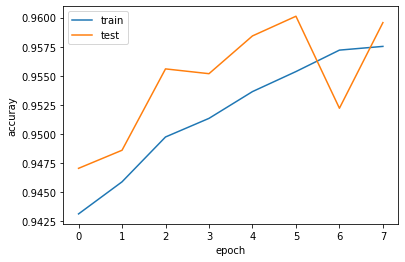

In [103]:
#Dos lineas de código
plt.plot(history.history['accuracy'])     # train acc
plt.plot(history.history['val_accuracy']) # test acc

plt.xlabel('epoch'); plt.ylabel('accuray')
plt.legend(['train', 'test'])

plt.show()

19. Lo mismo, pero con la pérdida

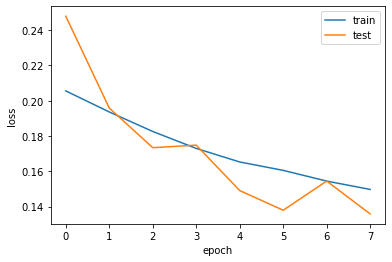

In [104]:
#Dos lineas de código
plt.plot(history.history['loss'])     # train acc
plt.plot(history.history['val_loss']) # test acc

plt.xlabel('epoch'); plt.ylabel('loss')
plt.legend(['train', 'test'])


plt.show()

**20. [1 linea codigo]** Calcula las predicciones del modelo con X_test.

In [106]:
y_pred = model.predict(X_test)

**21. [1 linea codigo]** ¿Que dimensiones tiene la predicción y_pred?

In [109]:
print(y_pred.shape)
print(y_test.shape)

(21889, 5)
(21889, 5)


22. Compara una predicción con el valor esperado utilizando un gráfico de barras.

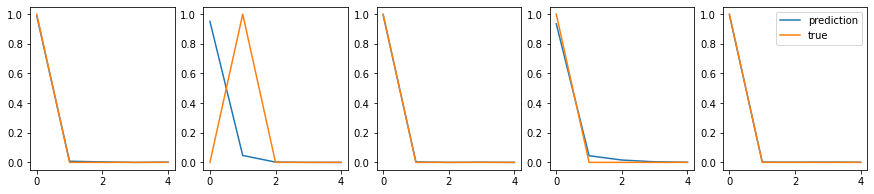

In [145]:
# vamos a plotear unos cuantos casos
n_cases = 5
pltsize = 3

f, ax = plt.subplots(nrows = 1, ncols = n_cases, figsize=(n_cases*pltsize, pltsize))

for i, _ in enumerate(range(0, 200, 15)[:n_cases]):
    ax[i].plot(range(n_classes), y_pred[_])
    ax[i].plot(range(n_classes), y_test[_])

plt.legend(['prediction', 'true'])
plt.show()


¿El modelo plantea una sola posibilidad o las probabilidades de cada categoria al estimar?
> *EL modelo plantea una probabilidad para cada categoría*

Este snippet de código genera un report del modelo, y el siguiente una matriz de confusión. Utilizadlo para evaluar vuestro modelo.

In [146]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18150
           1       0.97      0.45      0.61       539
           2       0.95      0.78      0.86      1394
           3       0.78      0.17      0.28       166
           4       1.00      0.93      0.96      1640

    accuracy                           0.96     21889
   macro avg       0.93      0.67      0.74     21889
weighted avg       0.96      0.96      0.95     21889



<u>NOTAS</u>

* Recall (la capacidad del modelo de devolver falsos negativos): Es *muy baja* para las categorias 1 y 3
* Precision (la capacidad del modelo de devolver falsos positivos): Es baja para la categoría 3

> El modelo es malo para predecir la categoría 3

Normalized confusion matrix


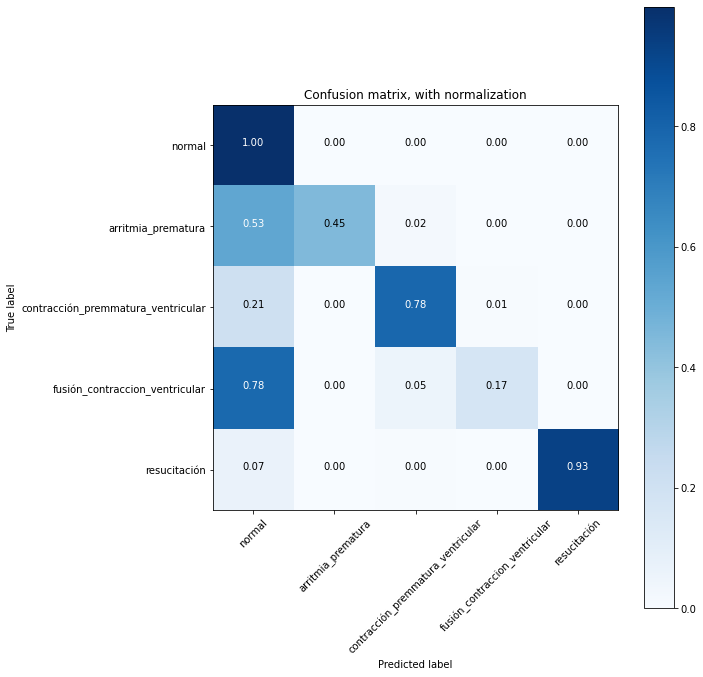

In [149]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Confusion matrix, with normalization'


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=label_names,
                      title='Confusion matrix, with normalization',
                      normalize=True)
plt.show()

**Preguntas:**
- Si tomamos todo lo que no sea normal como positivo, ¿el modelo se equivoca mas en falsos positivos o en falsos negativos?
> En **falso positivo**, pues devuelve como positivo (normal) casos que no pertenecen a esa categoría
- ¿Que categoría genera mayor error?
> Fusión contracción ventricular, pues la mayoría de los casos están mal predecidos como normales
- ¿Existe overfitting?
> En mi caso - que he modificado los parámetros de entrenamiento - creo que no; de hecho el accuracy del test es mayor que el del train (accuracy: 0.9575 < val_accuracy: 0.9596)
- ¿Como afecta batch_size al entrenamiento?
> El batch size es el número de instancias que toma por cada época para entrenar; cuanto mayor batch size, mayor tiempo de entrenamiento por epoch

Ahora os toca a vosotros mejorar el modelo. Probad con otros optimizadores, cambiar la función de coste, volveros locos con el batch_size..... El paper del principio puede dar alguna pista. Como siempre, el que tenga la mejor score, ¡tiene premio!

In [150]:
# Lo he dejado en lo que he obtenido : 0.9596 que no está mal